## Imports

In [ ]:
import os
import pandas as pd
import numpy as np
import hashlib
import io
import json
import pickle
import requests
import joblib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import ks_2samp
from plotchecker import LinePlotChecker, ScatterPlotChecker, BarPlotChecker
import seaborn as sns
import requests

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier, LGBMRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error


import lightgbm as lgb

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

C:\Users\catar\AppData\Local\Temp\ipykernel_16648\1405592005.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Functions

In [3]:
def grouped_weighted_mape_bias(df, group_cols, y_true_col, y_pred_col, quantity_col):
    # Function to compute weighted MAPE & BIAS
    grouped = df.groupby(group_cols).apply(lambda g: pd.Series({
        "mape": np.sum(np.abs(g[y_true_col] - g[y_pred_col]) * g[quantity_col]) / np.sum(g[y_true_col] * g[quantity_col]),
        "bias": np.sum((g[y_pred_col] - g[y_true_col]) * g[quantity_col]) / np.sum(g[quantity_col])
    }), include_groups=False)
    
    return grouped.reset_index()

In [4]:
def plot_feature_importance(model, feature_names, title):
    """Plots feature importance from LightGBM model after preprocessing"""

    # Extract LightGBM feature importance
    importance = model.named_steps["model"].feature_importances_

    # Ensure feature names align with importance array
    if len(feature_names) != len(importance):
        print(f"Warning: Feature name length ({len(feature_names)}) does not match importance length ({len(importance)}). Adjusting...")
        feature_names = feature_names[:len(importance)]  # Trim feature names if mismatch occurs

    # Create DataFrame
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importance
    })

    # Sort by importance
    importance_df = importance_df.sort_values(by="importance", ascending=False)

    # Plot
    plt.figure(figsize=(10, 10))
    sns.barplot(data=importance_df, x="importance", y="feature", hue="feature", legend=False, palette="coolwarm")
    plt.title(title)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()



## Read data

In [5]:
dtype_dict = {
    'structure_level_4': 'object',
    'structure_level_3': 'object',
    'structure_level_2': 'object',
    'structure_level_1': 'object',
    'sku': 'int64',
    'competitor': 'object',
    'chain_campaign': 'object',
    'quantity': 'float64',
    'pvp_was': 'float64',
    'discount': 'float64',
    'flag_promo': 'float64',
    'leaflet': 'object',
    'pvp_is': 'float64',
    'flg_filled_gap': 'float64',
    'month': 'int32',
    'day_of_week': 'int32',
    'week_of_month': 'int64',
    'holiday': 'object',
    'holiday_importance': 'int64',
    'apparent_temperature_mean': 'int64',
    'precipitation_sum': 'int64',
    'abc': 'object',
    'seil': 'object',
    'xyz': 'object',
    'pvp_is_lag_1': 'float64',
    'pvp_is_lag_7': 'float64',
    'pvp_is_lag_30': 'float64',
    'discount_lag_1': 'float64',
    'discount_lag_7': 'float64',
    'discount_lag_30': 'float64',
    'days_since_last_promo': 'float64',
    'rolling_mean_7': 'float64',
    'rolling_mean_30': 'float64',
    'avg_discount_w_L3': 'float64',
    'promo_part_w_L3': 'float64',
    'avg_discount_w_sku': 'float64',
    'promo_part_w_sku': 'float64',
    'discount_chain': 'float64',
    'leaflet_chain': 'object'
}

In [ ]:
df_input = pd.read_csv("prepared_data/data.csv",dtype=dtype_dict, parse_dates=['date'])
df_input['avg_discount_w_L3'] = df_input['avg_discount_w_L3'].round(2)
df_input['promo_part_w_L3'] = df_input['promo_part_w_L3'].round(2)
df_input['avg_discount_w_sku'] = df_input['avg_discount_w_sku'].round(2)
df_input['promo_part_w_sku'] = df_input['promo_part_w_sku'].round(2)

## Modelling

### LGMRegressor -> predict discount

In [29]:
list_structure_level_1=df_input['structure_level_1'].sort_values().unique()
list_competitor=df_input['competitor'].sort_values().unique()

In [ ]:
df2 = df_input[['sku', 'date','competitor', ## keys
                'discount', ## target 
                'pvp_was',
                'quantity', ## used for evaluation
                ## features:
                'structure_level_3', 'structure_level_1', #'structure_level_3', 'structure_level_2', 'structure_level_1', 
                'holiday_importance','avg_discount_w_L3','promo_part_w_L3','avg_discount_w_sku','promo_part_w_sku',
                'pvp_is_lag_7', 'discount_lag_7', 'days_since_last_promo',
                'month', 'day_of_week', 'week_of_month',
                'apparent_temperature_mean', 'precipitation_sum', 
                'abc', 'seil', 'xyz']]

***************************************************************************************************
Structure_level_1:  1
Competitor:  competitorA
df2_it:  346095

 Best Parameters for  competitorA  and structure_level_1  1 : 
 {'model__num_leaves': 20, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__learning_rate': 0.05}

 Weighted MAPE & BIAS for  competitorA  and structure_level_1  1 : 
   structure_level_1   competitor      mape      bias
0                 1  competitorA  0.098335  1.331074

 Weighted MAPE & BIAS by structure level 2:
   structure_level_2   competitor      mape      bias
0               101  competitorA  0.152380  2.228321
1               102  competitorA  0.039482  0.371717
2               103  competitorA  0.010456  0.099490
3               104  competitorA  0.073780 -0.181672
4               105  competitorA  0.001726 -0.053782
5               106  competitorA  0.007429  0.243168

Feature Importance - competitorA and structure_level_1: 
              

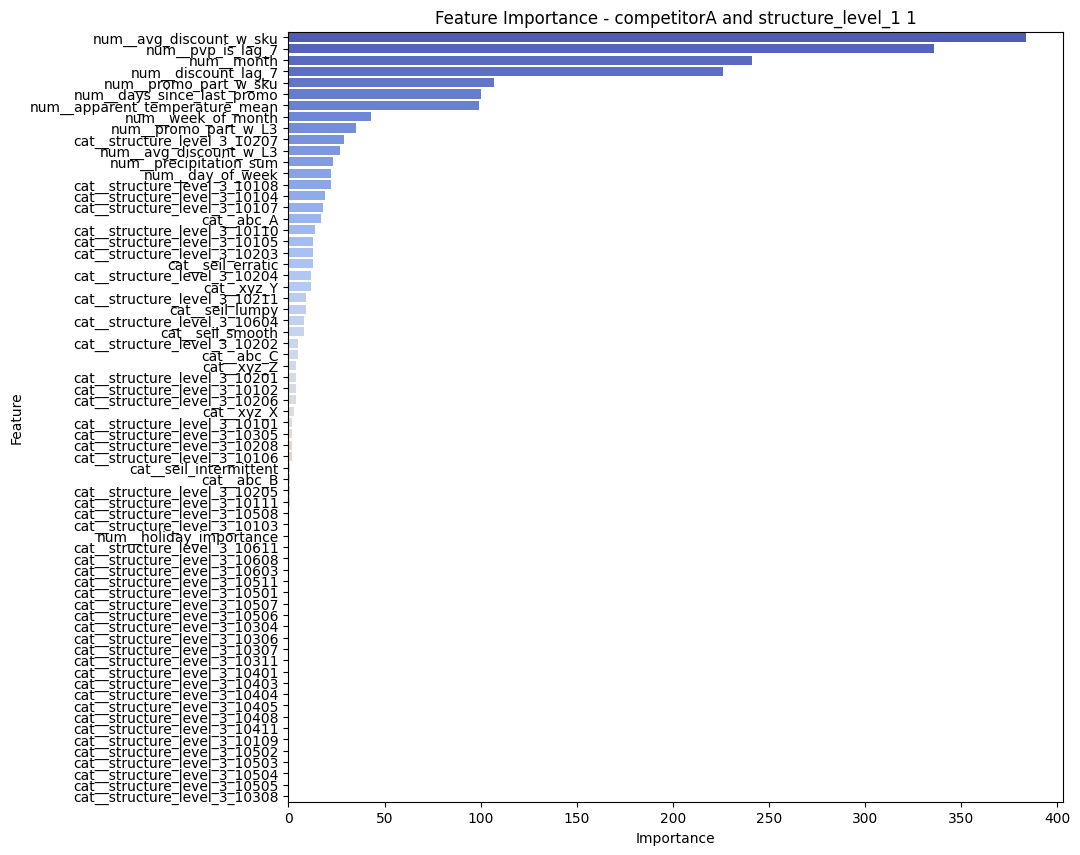

Model  final_model_it_structL1_1_competitorA.pickle  saved in ' models '


***************************************************************************************************
Structure_level_1:  1
Competitor:  competitorB
df2_it:  220328

 Best Parameters for  competitorB  and structure_level_1  1 : 
 {'model__num_leaves': 20, 'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.05}

 Weighted MAPE & BIAS for  competitorB  and structure_level_1  1 : 
   structure_level_1   competitor      mape      bias
0                 1  competitorB  0.093347  1.223243

 Weighted MAPE & BIAS by structure level 2:
   structure_level_2   competitor      mape      bias
0               101  competitorB  0.132393  2.422353
1               102  competitorB  0.056199 -0.039577
2               103  competitorB  0.018100 -0.187876
3               104  competitorB  0.057086 -1.446430
4               105  competitorB  0.039834 -0.731544
5               106  competitorB  0.004317 -0.1218

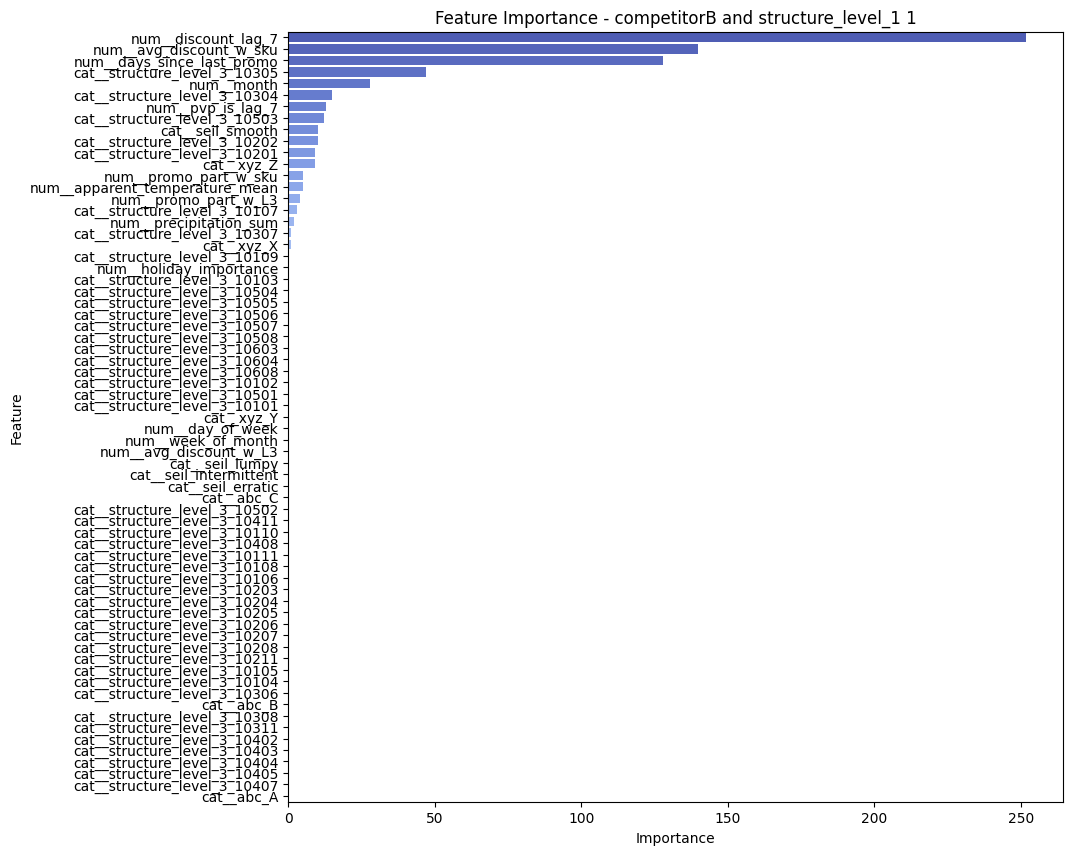

Model  final_model_it_structL1_1_competitorB.pickle  saved in ' models '




In [ ]:
## Train a model for each competitor and structure of level 1
all_predictions_lgbm_discount = []
for struct1 in list_structure_level_1:
    for comp in list_competitor:
        print("***************************************************************************************************")
        print("Structure_level_1: ", struct1)
        print("Competitor: ", comp)

        ## 1. Filter dataset
        df2_it = df2[((df2["competitor"] == comp) & (df2["structure_level_1"]==struct1))].copy()
        df2_it = df2_it.drop('structure_level_1', axis=1)
        print("df2_it: ", len(df2_it))


        ## 2. Define train-test split date (e.g., last 4 months for testing)
        excluded_cols = ["sku", "date", "competitor", "discount", "pvp_was", "quantity"]
        train_cutoff = pd.to_datetime("2024-06-04")  
        df2_it_train = df2_it[df2_it["date"] < train_cutoff]
        X_train_it = df2_it_train.drop(columns=excluded_cols)
        y_train_it = df2_it_train["discount"]
        df2_it_test = df2_it[df2_it["date"] >= train_cutoff]
        X_test_it = df2_it_test.drop(columns=excluded_cols)
        y_test_it = df2_it_test["discount"]

        ## 3. Apply Transformations
        categorical_features = ["abc", "seil", "xyz", 'structure_level_3']
        continuous_features = ["holiday_importance",
                            "apparent_temperature_mean", "precipitation_sum", 
                            "month", "day_of_week", "week_of_month", 'avg_discount_w_L3','promo_part_w_L3','avg_discount_w_sku','promo_part_w_sku',
                            'pvp_is_lag_7', 'discount_lag_7', 'days_since_last_promo']

        preprocessor = ColumnTransformer(
            transformers=[
                ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
                ("num", StandardScaler(), continuous_features)
            ])

        ## 4. Hyperparameter Tunning
        param_grid = {
            "model__learning_rate": [0.01, 0.05, 0.1],
            "model__n_estimators": [100, 300, 500],
            "model__max_depth": [3, 5, 7],
            "model__num_leaves": [20, 31, 40],
        }
        pipeline_it = Pipeline(steps=[("preprocessor", preprocessor), ("model", lgb.LGBMRegressor(random_state=42, verbose=-1))])
        random_search_it = RandomizedSearchCV(pipeline_it, param_grid,n_iter=81, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1, random_state=42, verbose=0)
        random_search_it.fit(X_train_it, y_train_it)
        best_params_it = random_search_it.best_params_
        print("\n Best Parameters for ", comp, " and structure_level_1 ", struct1, ": \n",  best_params_it)

        ## 5. Evaluate predictions
        df2_it_input = df_input[((df_input["competitor"] == comp) & (df_input["structure_level_1"]==struct1))].copy()
        best_model_it = random_search_it.best_estimator_
        y_pred_it = best_model_it.predict(X_test_it)
        final_preds_it = df2_it_input.loc[X_test_it.index].copy()
        final_preds_it["discount_pred"] = y_pred_it
        
        df_last_pvp_was = df2_it_train.groupby('sku').tail(1).reset_index(drop=True)[['sku', 'pvp_was']].rename(columns={"pvp_was":"last_pvp_was_train"})
        final_preds_it = final_preds_it.merge(df_last_pvp_was,on=['sku'], how='left')
        final_preds_it['pvp_is_pred'] = final_preds_it['last_pvp_was_train']*(1-final_preds_it['discount_pred'])

        all_predictions_lgbm_discount.append(final_preds_it)

        result_1 = grouped_weighted_mape_bias(final_preds_it, ["structure_level_1", "competitor"], "pvp_is", "pvp_is_pred", "quantity")
        print("\n Weighted MAPE & BIAS for ", comp, " and structure_level_1 ", struct1, ": \n", result_1)
        result_2 = grouped_weighted_mape_bias(final_preds_it, ["structure_level_2", "competitor"], "pvp_is", "pvp_is_pred", "quantity")
        print("\n Weighted MAPE & BIAS by structure level 2:\n", result_2)

        ## 6. Feature Importance
        X_train_transformed_it = best_model_it.named_steps["preprocessor"].transform(X_train_it)
        feature_names_it = best_model_it.named_steps["preprocessor"].get_feature_names_out()

        importance_values = best_model_it.named_steps["model"].feature_importances_
        feature_importance_df = pd.DataFrame({
            "Feature": feature_names_it,
            "Importance (%)": (importance_values / importance_values.sum()) * 100  # Normalize to %
        })
        feature_importance_df = feature_importance_df.sort_values(by="Importance (%)", ascending=False)
        print("\nFeature Importance - " + comp + " and structure_level_1: ")
        feature_importance_df.to_csv(f"feature_imp/feature_importance_structL1_{struct1}_{comp}.csv")

        print(feature_importance_df)
        plot_feature_importance(best_model_it, feature_names_it, "Feature Importance - " + comp + " and structure_level_1 " + struct1)


        # 7. Retrain model on full dataset
        clean_params_it = {key.replace("model__", ""): value for key, value in best_params_it.items()}
        final_model_it = Pipeline(steps=[("preprocessor", preprocessor), ("model", lgb.LGBMRegressor(**clean_params_it))])
        X_it = df2_it.drop(columns=excluded_cols)
        y_it = df2_it["discount"]
        final_model_it.fit(X_it, y_it)
        
        ## 8. Save Model
        TMP_DIR = 'models'
        joblib.dump(final_model_it, os.path.join(TMP_DIR, f'final_model_it_structL1_{struct1}_{comp}.pickle'))
        print("Model ", f'final_model_it_structL1_{struct1}_{comp}.pickle',  " saved in '", TMP_DIR, "'\n\n")

df_all_predictions_lgbm_discount = pd.concat(all_predictions_lgbm_discount, ignore_index=True)


In [101]:
df_all_predictions_lgbm_discount.to_csv("20250512_df_all_predictions_lgbm_discount_STRUCTL1_2_3.csv")